In [1]:
import os
from pathlib import Path
import pandas as pd

In [2]:
dataset = Path("/home/medhyvinceslas/Documents/programming/datasets/image_captioning_flickr30k_images")
annotations = dataset / "annotations_cleaned.csv"
image_folder = dataset / "flickr30k_images"

In [3]:
df = pd.read_csv(annotations)
df

,image_name,comment
0,1000092795.jpg,['Two young guys with shaggy hair look at thei...
1,10002456.jpg,['Several men in hard hats are operating a gia...
2,1000268201.jpg,['A child in a pink dress is climbing up a set...
3,1000344755.jpg,['Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"['Two men , one in a gray shirt , one in a bla..."
...,...,...
31778,997338199.jpg,"['Woman writing on a pad in room with gold , d..."
31779,997722733.jpg,['A person in a red shirt climbing up a rock f...
31780,997876722.jpg,"[""Two male construction workers are working on..."
31781,99804383.jpg,['An older busker in glasses plays an Eastern ...


### Create vocabulary

In [134]:
with open('../word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

In [135]:
len(word2idx)

20295

### Visualizing the data

In [136]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

A black dog and a white dog with brown spots are staring at each other in the street .
A black dog and a tri-colored dog playing with each other on the road .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
A black dog and a spotted dog are fighting



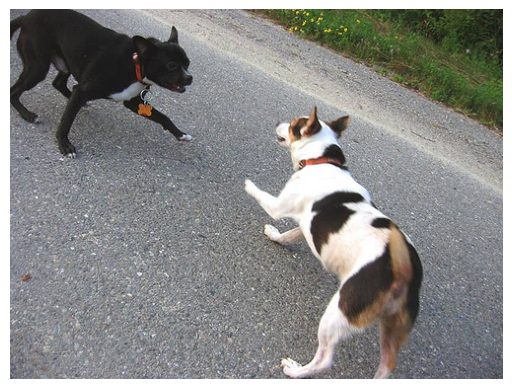

In [137]:
idx = 12
image = mpimg.imread(image_folder / df.image_name[idx])
captions = df.comment[idx]

if not isinstance(captions, list):
    captions = eval(captions)
    
assert isinstance(captions, list)

for caption in captions:
    print(caption)

plt.axis("off")
plt.imshow(image)
print("")

### Simulate loading of the data for PyTorch

In [138]:
import torch
import numpy as np

#### Sample one caption at random

In [139]:
caption = captions[np.random.randint(0, len(captions))]
caption

'Two dogs on pavement moving toward each other .'

#### standardize

In [140]:
caption_lw = caption.lower()
caption_lw

'two dogs on pavement moving toward each other .'

#### tokenize

In [141]:
tokens = word_tokenize(caption_lw)
tokens

['two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other', '.']

#### reformat

In [142]:
caption_enriched = []
caption_enriched.append('<start>')
caption_enriched.extend([token for token in tokens])
caption_enriched.append('<end>')
caption_enriched

['<start>',
 'two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'toward',
 'each',
 'other',
 '.',
 '<end>']

#### now I need to encode map each words with an integer thanks to the map file

In [143]:
caption_integer = [word2idx[i] for i in caption_enriched]
caption_integer

[4557, 2122, 11053, 14564, 16818, 9509, 12394, 1008, 5481, 8083, 15335]

#### Each caption in the dataset do not have the same length, to we will pad all caption that have a length smaller that max_sequence_length

In [144]:
# let's chose max_sequence_length
max_seq_length = 20
print(f"Value of pad is {word2idx['<PAD>']}")

# create n pad values (n = max_seq_length)
padded = np.ones((max_seq_length,), dtype=np.int64) * word2idx['<PAD>']

# if the sentence is longer than the max length, we slice it and keep only the first n
if len(caption_integer) > max_seq_length:
    padded[:] = s[:max_seq_length]
    
# otherwise we pad
else:
    padded[:len(caption_integer)] = caption_integer

padded

Value of pad is 7803


array([ 4557,  2122, 11053, 14564, 16818,  9509, 12394,  1008,  5481,
        8083, 15335,  7803,  7803,  7803,  7803,  7803,  7803,  7803,
        7803,  7803])

### Let's put everything in a class and visualize the output from the PyTorch DataLoader

In [145]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """Image Caption dataset."""

    def __init__(self, csv_file, image_folder, word2idx_file, max_seq_length=20, transform=None):
        self.max_seq_length = max_seq_length
        
        self.df = pd.read_csv(csv_file)                
        self.image_folder = image_folder
        self.transform = transform
        
        with open(word2idx_file, 'rb') as f:
            self.word2idx = pickle.load(f)
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # read an image and its list of captions
        image = mpimg.imread(self.image_folder / self.df.image_name[idx])
        captions = df.comment[idx]

        if not isinstance(captions, list):
            captions = eval(captions)
        assert isinstance(captions, list)
        
        # select one caption at random from the list and process it
        caption = captions[np.random.randint(0, len(captions))]
        caption_lw = caption.lower()
        tokens = word_tokenize(caption_lw)
        
        # add the made-up start and end tokens and transform all token to integer
        caption_enriched = []
        caption_enriched.append('<start>')
        caption_enriched.extend([token for token in tokens])
        caption_enriched.append('<end>')        
        caption_integer = [self.word2idx[i] for i in caption_enriched]
        
        # pad the sequence
        padded_caption = self.pad_data(caption_integer)
        
        sample = {'image': image, 'caption': padded_caption}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    
    
    def pad_data(self, s):
        padded = np.ones((self.max_seq_length,), dtype=np.int64)*self.word2idx['<PAD>']
        
        if len(s) > self.max_seq_length:
            padded[:] = s[:self.max_seq_length]
        else: 
            padded[:len(s)] = s
            
        return padded

In [146]:
import cv2

class Normalize(object):

    def __call__(self, sample):
        image, caption = sample['image'], sample['caption']
        
        image_copy = np.copy(image)
        image_copy =  image_copy/255.0
        
        return {'image': image_copy, 'caption': caption}



class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, caption = sample['image'], sample['caption']
        
        img = cv2.resize(image, (self.output_size, self.output_size))
          
        return {'image': img, 'caption': caption}




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, caption = sample['image'], sample['caption']
         
        # if image has no RGB color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 3)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        caption = torch.Tensor(caption).long()
        
        return {'image': torch.from_numpy(image), 'caption': caption}

In [148]:
import torchvision.transforms as T
transform = T.Compose([
    Rescale(224),
    Normalize(),
    ToTensor()
])

train_set = CustomDataset(annotations, image_folder, word2idx_file="../word2idx.pkl", max_seq_length=20, transform=transform)

In [149]:
from torch.utils.data.sampler import SubsetRandomSampler

def train_valid_split(training_set, validation_size):    
    # obtain training indices that will be used for validation
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return train_sampler, valid_sampler


train_sampler, valid_sampler = train_valid_split(train_set, validation_size=0.3)
train_sampler, valid_sampler

(<torch.utils.data.sampler.SubsetRandomSampler at 0x7ff58ee92200>,
 <torch.utils.data.sampler.SubsetRandomSampler at 0x7ff58c21ec50>)

In [150]:
batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
train_loader, valid_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ff58ed1ee60>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff59d5ed0f0>)

#### Visualize loaded data

<start> a man in a black jacket with a white stripe on the sleeve is holding a drink and laughing



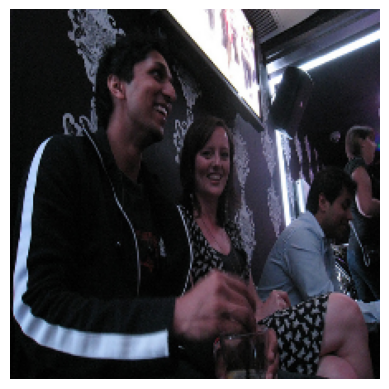

In [151]:
data = next(iter(train_loader))
images, targets = data["image"], data["caption"]
caption = targets[0]
im = images[0]
im = im.numpy().transpose((1, 2, 0))

idx2word = {v: k for k, v in train_set.word2idx.items()}
caption_string = [idx2word[i.item()] for i in caption]
caption_string = " ".join(caption_string)

print(caption_string)

plt.axis("off")
plt.imshow(im)
print("")

### Data loading is working 🎉

## Building architecture

##### The feature extractor from an image in done by a CNN: The encoder (encoding the content of an image into a smaller feature vector)
##### The caption prediction in done by a RNN with LSTM cells: The decoder

#### Encoder

__Here I will take a normal CNN__

<img src="https://imgs.search.brave.com/qQJ1lj09fA2NATiUYG3BgFfaRhzvsF_YNKpbUPm0rNU/rs:fit:600:342:1/g:ce/aHR0cHM6Ly9waWM0/LnpoaW1nLmNvbS92/Mi1iMTkyOTBlNWY5/MDUzODc2MGFiYzY4/YWJmYjJjNzZlYl9y/LmpwZw">

- __And get ride of the last FC layers + activation and only keep the spatial information (given by the last pooling layer)__ <== freeze gradients  
- __Then add a final FC that will prepare the extracted feature for the RNN__ <== This last layer is trainable


In [152]:
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, device):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # additional Fully connected layer with an output = the embed size to be fed to the rnn
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        
        self.resnet.to(device)

    def forward(self, images):
        features = self.resnet(images)
        
        # flatten for our additional fc layer
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

#### Decoder
During training, to be able to upddate the weights the __model needs to compute a loss in order to know how close the prediction is from the GT__. From here let's say the word "Hello" is encoded as 1 and the word "Hi" is encoded as 494749. Even if these words are similar (as a human being), for the computer they are completely different. So it cannot gives an idea of how close these words are in order to compute the error. That is the job of the __Embedding layer__.  

- __construct embedding layer: it transform each input words into a vector of a desired and consistent shape, for the RNN__
- __create the LSTM__
- __add a final FC layer__

In [153]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, device):
        super().__init__()
        """
        - embed_size: size of the embedding layer, should match the size of the output linear layer of the CNN (this is the input_size of the RNN)
        - hidden_size: max number of outputs between layers
        - vocab_size: 
        - num_layers: number of stacked LSTM cells (2-3 works best in practice)
        """

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        # embedding layer and the LSTM cell
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        
        # batch_first: if True, then the input and output tensors are provided as (batch, seq, feature)
        self.lstm = nn.LSTM(embed_size, self.hidden_size, self.num_layers, batch_first=True)
        

        # The linear layer maps the hidden state output of the LSTM to the number of words we want: vocab_size
        self.linear = nn.Linear(self.hidden_size, vocab_size)

    def init_hidden(self, batch_size):
        """ 
        Here we need to define h0, c0 (stm and ltm) with all zeroes in order to initialize our LSTM cell
        """
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size))
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size))
        return h0.to(self.device), c0.to(self.device)
    
    
    def forward(self, features, captions):
        features = features.to(self.device)
        captions = captions.to(self.device)
        
        batch_size = features.shape[0]

        # Initialize the hidden state
        self.hidden = self.init_hidden(batch_size)
        
        # print(self.hidden[0].shape)

        # Create embedded word vectors for each word in the captions
        embeddings = self.word_embeddings(captions)

        # Stack the features and captions
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)

        lstm_out, self.hidden = self.lstm(embeddings, self.hidden)

        out = self.linear(lstm_out)

        out = out[:, :-1]

        return out
    
    
    def sample(self, inputs, word2idx, max_length=20):
        """
        Takes an image tensor (inputs) and returns predicted sentence (list of tensor ids of max_length)
        """
        
        output = []
        
        batch_size = inputs.shape[0]
        
        #Initialize from LSTM
        hidden = self.init_hidden(batch_size)
    
        while True:
            
            lstm_out, hidden = self.lstm(inputs, hidden)
            
            out = self.linear(lstm_out)
            out = out.squeeze(1)
            
            # predict next word
            _, ids = torch.max(out, dim=1)
            
            # get the predicted word
            output.append(ids.cpu().numpy()[0].item()) # storing the word predicted
            
            # stop when we predict the <end> word
            if (ids == word2idx["<end>"] or len(output) == 50):
                break
            
            # new input using the predicted word
            inputs = self.word_embeddings(ids) 
            inputs = inputs.unsqueeze(1)
            
        return output

### Train

In [156]:
embed_size = 256
hidden_size = 512
vocab_size = len(train_set.word2idx)
n_epochs = 1
batch_size = 4

train_set = CustomDataset(annotations, image_folder, word2idx_file="../word2idx.pkl", max_seq_length=20, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN(embed_size, device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=2, device=device)

encoder = encoder.to(device)
decoder = decoder.to(device)

criterion = nn.CrossEntropyLoss().to(device)
params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

print(device)

/home/medhyvinceslas/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/medhyvinceslas/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [110]:
valid_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):

    train_loss = 0.0
    valid_loss = 0.0

    encoder.train()
    decoder.train()
    for data in train_loader:
        images, captions = data["image"], data["caption"]
        images = images.type(torch.FloatTensor)
        images.to(device)
        captions.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    encoder.eval()
    decoder.eval()
    for data in valid_loader:
        images, captions = data["image"], data["caption"]
        images = images.type(torch.FloatTensor)
        images.to(device)
        captions.to(device)

        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))

        valid_loss += loss.item() * images.size(0)

    # Average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    print(f"Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}")

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...")
        torch.save(encoder.state_dict(), "/home/medhyvinceslas/Documents/programming/Image_Captioning/weights/encoder.pt")
        torch.save(decoder.state_dict(), "/home/medhyvinceslas/Documents/programming/Image_Captioning/weights/decoder.pt")
        valid_loss_min = valid_loss


KeyboardInterrupt



In [157]:
with open('../word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

encoder.load_state_dict(
    torch.load("/home/medhyvinceslas/Documents/programming/Image_Captioning/weights/encoder.pt", map_location=device)
)
decoder.load_state_dict(
    torch.load("/home/medhyvinceslas/Documents/programming/Image_Captioning/weights/decoder.pt", map_location=device)
)

encoder.eval()
decoder.eval()

DecoderRNN(
  (word_embeddings): Embedding(20295, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True)
  (linear): Linear(in_features=512, out_features=20295, bias=True)
)

<start> a dog runs through the grass . <end>



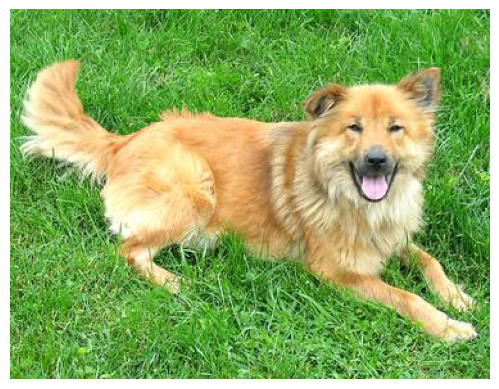

In [172]:
# pre-process
im_path = "/home/medhyvinceslas/Documents/programming/datasets/image_captioning_flickr30k_images/flickr30k_images/301246.jpg"
im_path = "/home/medhyvinceslas/Documents/programming/datasets/dog_cat_classification/test/data/4.jpg"

image = mpimg.imread(im_path)

transform = T.Compose([
    Rescale(224), Normalize(), ToTensor()
])
sample = {"image": image, "caption": [0]}

sample = transform(sample)
img_tensor = sample["image"]
img_tensor = img_tensor.type(torch.FloatTensor)
img_tensor = img_tensor.to(device)
img_tensor = img_tensor.unsqueeze(0)

# forward
features = encoder(img_tensor).unsqueeze(1)
output = decoder.sample(features, word2idx)

# display
idx2word = {v: k for k, v in word2idx.items()}

assert all([isinstance(x, int) for x in output]), "items in output tensor should be integer"
assert all([x in idx2word for x in output]), "items in the output needs to correspond to an integer in the vocabulary."

caption_string = [idx2word[i] for i in output]
caption_string = " ".join(caption_string)
print(caption_string)

plt.axis("off")
plt.imshow(image)
print("")